# Load Useful Functions

In [1]:
%run "0_Helper_Function_GLM_VOL_OMR.ipynb"

...
----------------------------------------------------------------------
Ran 3 tests in 5.618s

OK


In [2]:
from scipy.ndimage.filters import maximum_filter1d 
def max_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return maximum_filter1d(a,size=W,mode='reflect')#[hW:-hW]

In [3]:
def detect_tail_bouts(tail_angle,NumSegments=9,BCFilt=10,MinFiltSize=20,MaxFiltSize=400,BoutThresh=0.1,MinLength=40,MinAmpl=0.25):

    # Define Cumul Sum and Find Tracking Nan:
    error_flag=np.where(np.min(tail_angle,1)<-50)[0]
    tail_angle[tail_angle==-100]=0
    cumul_tail_angle=np.cumsum(tail_angle,1)
    num_errors=error_flag.shape[0]

    # For the bout detection we smooth the tail curvature to eliminate kinks due to tracking noise
    notrack=np.where(np.sum(cumul_tail_angle,1)==0)[0]
    print('Shape of No Track:')
    print(notrack.shape)
    smooth_cumul_tail_angle=np.copy(cumul_tail_angle)
    for n in range(1,cumul_tail_angle.shape[1]-1):
        smooth_cumul_tail_angle[:,n]=np.mean(cumul_tail_angle[:,n-1:n+2],1)

    for n in range(cumul_tail_angle.shape[1]):
        tmp=cumul_tail_angle[:,n]
        tmp=signal.savgol_filter(tmp, 11, 2, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        smooth_cumul_tail_angle[:,n]=tmp
    
    # Compute difference in segment angles, because we want to detect tail movement
    tmp=np.diff(smooth_cumul_tail_angle,axis=0)
    z=np.zeros((1,tmp.shape[1]))
    fixed_segments_angles=np.vstack((z,tmp))
    fixed_segments_angles[notrack,:]=0
    
    # Interpolate on NoTrack
    if notrack.shape[0]>0:
        if notrack[-1]==tail_angle.shape[0]-1:
            fixed_segments_angles[notrack[:-1]+1,:]=0
        else:
            fixed_segments_angles[notrack+1,:]=0
    real_segment_angles = fixed_segments_angles[:,0:NumSegments];
    
    # Smooth the tail movement
    filtered_segment_angles=np.zeros_like(real_segment_angles)
    for i in range(real_segment_angles.shape[1]):
        filtered_segment_angles[:,i]= signal.convolve(
            real_segment_angles[:,i],
            1/BCFilt*signal.boxcar(M=BCFilt,sym=False),
            mode='same')

    # Sum the angle differences down the length of the tail to give prominence to regions of continuous curvature in one direction
    cumul_filtered_segment_angles=np.cumsum(filtered_segment_angles,1)

    # Sum the absolute value of this accumulated curvature so bends in both directions are considered
    super_cumul_filtered_segment_angles = np.cumsum(np.abs(cumul_filtered_segment_angles),1)
    tail_curv_measure= signal.convolve(
            super_cumul_filtered_segment_angles[:,-1],
            1/BCFilt*signal.boxcar(M=BCFilt,sym=False),
            mode='same')

    # max filter flattens out beat variations (timescale needs to be adjusted according to be well below the interbout length)
    max_filt=max_filter1d_valid(tail_curv_measure,MinFiltSize)
    # min filter removes baseline fluctuations (needs to be well above the bout length)
    min_filt=-max_filter1d_valid(-tail_curv_measure,MaxFiltSize)
    smoother_tail_curve_measure=max_filt-min_filt

    # Find when tail is active
    all_bout=smoother_tail_curve_measure>BoutThresh
    all_bout_f=all_bout.astype(float) 

    tmp=np.diff(all_bout_f,axis=0)
    tmp=np.hstack((0,tmp))
    tmp=np.vstack((tmp,np.zeros_like(tmp)))
    all_bout_start=np.max(tmp,0)

    tmp=-1*np.diff(all_bout_f,axis=0)
    tmp=np.hstack((0,tmp))
    tmp=np.vstack((tmp,np.zeros_like(tmp)))
    all_bout_end=np.max(tmp,0)

    all_bout_start_ind=np.where(all_bout_start)[0]
    all_bout_end_ind=np.where(all_bout_end)[0]
    if all_bout_start_ind[0]>all_bout_end_ind[0]:
        all_bout_end_ind=all_bout_end_ind[1:]

    if len(all_bout_start_ind)>len(all_bout_end_ind):
        all_bout_start_ind=all_bout_start_ind[0:-1]

    bout_duration=np.zeros_like(all_bout_start_ind)
    bout_ampl=np.zeros_like(all_bout_start_ind)
    for i in range(len(all_bout_start_ind)):
        bout_duration[i]=all_bout_end_ind[i]-all_bout_start_ind[i]
        bout_ampl[i]=np.max(smoother_tail_curve_measure[all_bout_start_ind[i]:all_bout_end_ind[i]])

    bad_bouts=(bout_duration<MinLength)&(bout_ampl<MinAmpl)

    good_bout_start_ind=all_bout_start_ind[~bad_bouts]
    good_bout_end_ind=all_bout_end_ind[~bad_bouts]
    bad_bout_start_ind=all_bout_start_ind[bad_bouts]
    bad_bout_end_ind=all_bout_end_ind[bad_bouts]
    
    bouts = {'cumul_tail_angle': cumul_tail_angle, 'smooth_cumul_tail_angle': smooth_cumul_tail_angle,
           'cumul_filtered_segment_angles': cumul_filtered_segment_angles,'super_cumul_filtered_segment_angles': super_cumul_filtered_segment_angles,
           'all_bout': all_bout,'all_bout_start':all_bout_start,'all_bout_end':all_bout_end,
            'all_bout_start_ind': all_bout_start_ind,'all_bout_end_ind': all_bout_end_ind,
           'good_bout_start_ind': good_bout_start_ind,'good_bout_end_ind': good_bout_end_ind,
           'bad_bout_start_ind': bad_bout_start_ind,'bad_bout_end_ind': bad_bout_end_ind
           }
    
    return bouts

# Test Function:

In [4]:
PlotFlag=False
Cluster=True
i_fish=1

if PlotFlag:

    if Cluster:
        filename_lin='/mnt/HDD_ORGERLAB/adrien/ExperimentalData/GLM_VOL_OMR/GLM_VOL_OMR_Table.csv'
    else:
        pass
        #filename_win='C:\\Users\\Adrien\\Desktop\\Code\\behavior_ontogeny\\Ontogeny_OMR_VOL\\Matlab\\OMR_Ontogeny_VOL_Table_wStim_wBouts.csv'
        #filename_lin=ConvertFilenameWindows2Linux(filename_win)
    
    ExperimentsList=pd.read_csv(filename_lin)
    if Cluster:
        filename_lin=ExperimentsList.fish_folder_cluster[i_fish] + '/' + ExperimentsList.fish_filename[i_fish]
        filename_mat=Path(filename_lin.replace('.txt','.mat'))
        filename_pkl=Path(filename_lin.replace('.txt','.pickle'))
    else:
        filename_win=ExperimentsList.fish_folder[i_fish] + '\\' + ExperimentsList.fish_filename[i_fish]
        filename_lin=ConvertFilenameWindows2Linux(filename_win)
        filename_mat=Path(filename_lin.replace('.txt','.mat'))
        filename_pkl=Path(filename_lin.replace('.txt','.pickle')) 
    cam_log=pd.read_pickle(filename_pkl) # cam_log=pd.read_csv(filename_csv)
    df = cam_log.filter(like='tail_angle')
    tail_angle=df.as_matrix()
    tail_angle[np.isnan(tail_angle)]=-100

    
    bouts=detect_tail_bouts(tail_angle)
    
    NumSegments=7
    
    colors = plt.cm.jet(np.linspace(0,1,NumSegments))


Shape of No Track:
(1066,)


In [5]:
IdSt=30*60*700
Duration=3*700
NumSegments=7


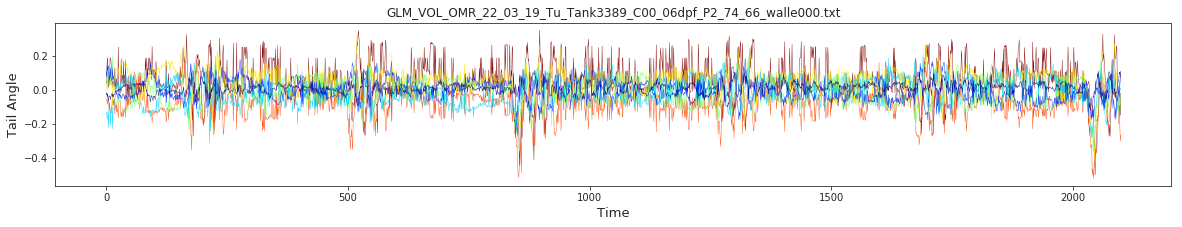

In [6]:
if PlotFlag:
    fig = plt.figure(figsize=(20,3))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(tail_angle[IdSt:IdSt+Duration,j], color=colors[j],lw=.4)
    plt.show()

In [7]:
if PlotFlag:
    fig = plt.figure(figsize=(7,3))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(bouts['cumul_tail_angle'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)
    plt.show()    

In [8]:
if PlotFlag:
    fig = plt.figure(figsize=(7,3))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)
    plt.show()

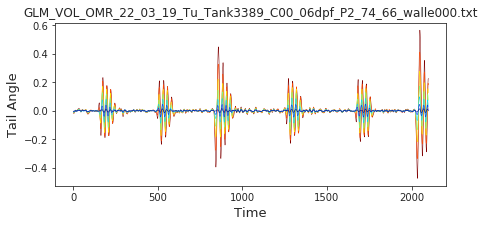

In [9]:
if PlotFlag:
    fig = plt.figure(figsize=(7,3))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(bouts['cumul_filtered_segment_angles'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)
    plt.show()    

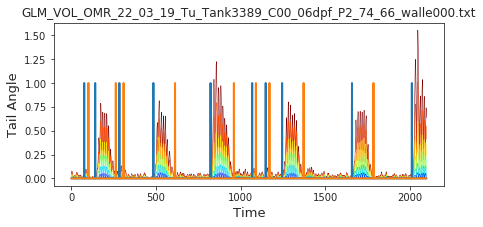

In [10]:
if PlotFlag:
    fig = plt.figure(figsize=(7,3))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(bouts['super_cumul_filtered_segment_angles'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)

    plt.plot(bouts['all_bout_start'][IdSt:IdSt+Duration],lw=2)
    plt.plot(bouts['all_bout_end'][IdSt:IdSt+Duration],lw=2)
    plt.show()

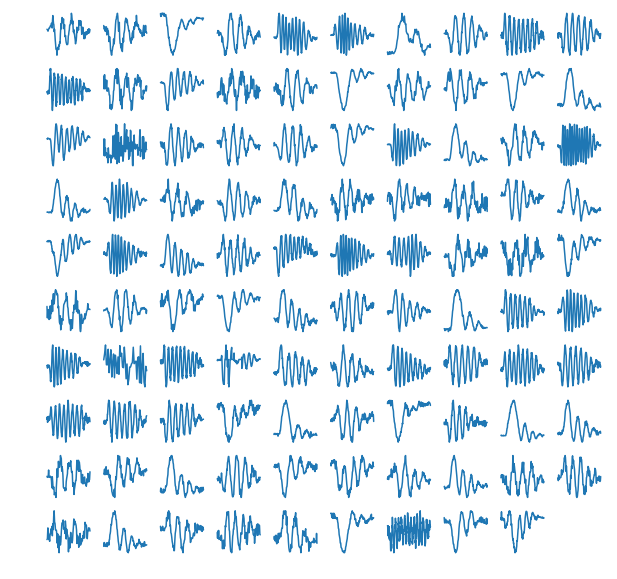

In [11]:
 if PlotFlag:
        
    import matplotlib.gridspec as gridspec
    gridnum=np.ceil(np.sqrt(bouts['good_bout_start_ind'].shape[0]))
    plt.figure(figsize=(10,10))

    if (gridnum<11):
        G = gridspec.GridSpec(gridnum,gridnum)
        for n in range(bouts['good_bout_start_ind'].shape[0]):
            [i,j]=np.unravel_index(n, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            axis.plot(bouts['cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],7])
    else:
        gridnum=10
        G = gridspec.GridSpec(gridnum,gridnum)

        stepsize=np.floor(bouts['good_bout_start_ind'].shape[0]/100);
        count=1;
        for i, i_val in enumerate(np.arange(stepsize,stepsize*100,stepsize).astype(int)):
            [i,j]=np.unravel_index(i, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            axis.plot(bouts['cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],7])
            axis.axis('off')
    plt.show()      

In [12]:
 if PlotFlag:
    gridnum=np.ceil(np.sqrt(bouts['bad_bout_start_ind'].shape[0]))
    plt.figure(figsize=(10,10))
    if (gridnum<11):
        G = gridspec.GridSpec(gridnum,gridnum)
        for n in range(bouts['bad_bout_start_ind'].shape[0]):
            [i,j]=np.unravel_index(n, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            axis.plot(bouts['cumul_tail_angle'][bouts['bad_bout_start_ind'][i_val]:bouts['bad_bout_end_ind'][i_val],7])
    else:
        gridnum=10
        G = gridspec.GridSpec(gridnum,gridnum)

        stepsize=np.floor(bouts['bad_bout_start_ind'].shape[0]/100);
        count=1;
        for i, i_val in enumerate(np.arange(stepsize,stepsize*100,stepsize).astype(int)):
            [i,j]=np.unravel_index(i, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            axis.plot(bouts['cumul_tail_angle'][bouts['bad_bout_start_ind'][i_val]:bouts['bad_bout_end_ind'][i_val],7])
            axis.axis('off')
    plt.show()

# Classify Tail Bouts:

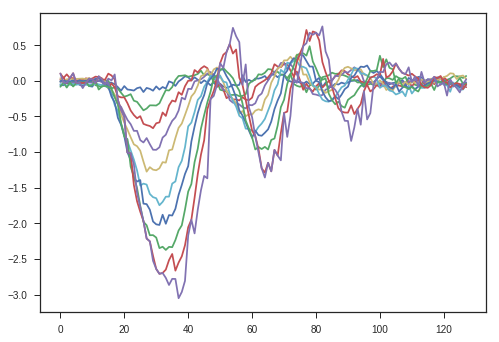

In [20]:
plt.figure()
plt.plot(bouts['cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],:])
plt.show()

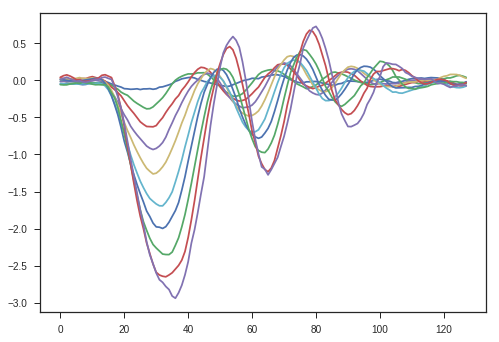

In [22]:
plt.figure()
plt.plot(bouts['smooth_cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],:])
plt.show()

In [18]:
bouts

{'all_bout': array([False, False, False, ..., False, False, False], dtype=bool),
 'all_bout_end': array([ 0., -0., -0., ..., -0., -0., -0.]),
 'all_bout_end_ind': array([    356,     951,    1429, ..., 9413086, 9413873, 9448315]),
 'all_bout_start': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'all_bout_start_ind': array([    188,     819,    1298, ..., 9413028, 9413766, 9448212]),
 'bad_bout_end_ind': array([   4598,    7926,    8263, ..., 9380114, 9396040, 9396088]),
 'bad_bout_start_ind': array([   4572,    7903,    8237, ..., 9380091, 9396006, 9396058]),
 'cumul_filtered_segment_angles': array([[  1.24777717e-03,   1.84709339e-03,   3.89702554e-03, ...,
           1.27133700e-03,   4.87951187e-03,   2.08395753e-03],
        [  1.33522324e-03,   1.90154614e-03,   4.13954185e-03, ...,
           1.06747911e-03,   4.27321837e-03,   9.46258199e-04],
        [  1.29818201e-03,   1.60736782e-03,   4.14795254e-03, ...,
           1.37537653e-04,   2.41269830e-03,  -3.12772720e-03],
      